## Good resource for multi-class classification in sklearn:
https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362

# Scoring metrics advice from Peng:


Figure 6 or 5: Results of machine learning including Random Forest – 20% complete
            Figure in early stages. 
@Peng I would greatly appreciate your expert feedback on how to best display results of machine learning models for:
-	Multiclass classification (predicting normal vs impaired vs diabetic), 
o	I’m working on a confusion matrix for the multiclass classification case. – Confusion matrix is a great way to display the prediction results for multi-class model. For visualization purpose, I would suggest to display one more figure: The RF probability distribution. For each sample, you will have three Prob values: Prob (normal), Prob (impaired) and Prob( diabetic). The sum of the three is 1. When you group samples from each category (e.g., normal), you can calculate the “distribution” of Prob for each predicted classes (Prob (normal), Prob (impaired) and Prob( diabetic) via boxplot or violin plot. We expect to see that for the group of “normal”, the boxplot/violin plot of “Prob (Normal)” is the highest, followed by Prob (impaired) and Prob( diabetic). … This figure can give an intuitive way to see the prediction distribution. I like the confusion table but the problem is that the confusion table is based on the “cutoff: RF use the highest prob to decide the outcome”. The Prob distribution is an unbiased way to display your prediction results.

-	Regression (predicting the blood glucose taken each week, or predicting OGTT) – A simply x-y plot with Pearson Correlation Coefficient or lm line can demonstrate the performance of RFR model
-	Comparing whether a model trained on random-fed data is meaningfully better than fasted data alone – A prediction score (Prob) comparison can demonstrate the difference. For example, you build a 3-calss model. For “normal samples”, you can show a boxplot/violin plot (Prob (Normal – random-fed)) vs (Prob (Normal – fasted)). Similarity, you can do this for each class to compile a figure panel.


In [1]:
import json
from collections import defaultdict

import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from models.data_subset_hyperparam_search import data_subset_hyperparam_search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')
import seaborn as sns
import dateutil
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    log_loss,
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
from models.data_subset_hyperparam_search import data_subset_hyperparam_search

In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

qval_sampling = data['fdr corrected pval effect of sampling']
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [158]:
y_3class = fg['gluc_tol']                                                 # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg['bg']                                                           # random/fasted blood glucoose
y_ogtt = fg['animal'].map(ap['OGTT (AUC)'])
y_weight = fg['animal'].map(ap['Weightprefastweek12'])
y_insulin = fg['animal'].map(ap['Insulin (AUC)'])

X_all = data.loc[:, y_3class.index.values].T
X_centered = pd.DataFrame(StandardScaler(with_std=False).fit_transform(X_all), index=data_cols, columns=data.index)
X_zscore = pd.DataFrame(StandardScaler().fit_transform(X_all), index=data_cols, columns=data.index)

# generate new rbg_cols and fbg_cols that retain the order from fg
rbg_cols = fg.loc[fg['bg_type'] == 'RBG'].index
fbg_cols = fg.loc[fg['bg_type'] == 'FBG'].index

### Playing with scoring metrics for use in `GridSearchCV` `scoring` parameter:
- `log_loss` https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss
- `accuracy` https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
- `F1` https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

In [4]:
labels = [0, 1, 2]
y_true = [1, 0, 0]
# y_prob_pred = [[0.5, 0.25, 0.25], [0.5, 0.25, 0.25], [0.5, 0.25, 0.25]]
y_prob_pred = [[0, 0, 0], [0.5, 0, 0], [0.9, 0.2, 0]]
y_pred = [2, 0, 0]
print(log_loss(y_true=y_true, y_pred=y_prob_pred, labels=labels))

# for multi-class, F1 score can only use one of average={None, 'micro', 'macro', 'weighted'}
print(f1_score(y_true=y_true, y_pred=y_pred, labels=labels, average='micro'))


0.433094328043422
0.6666666666666666


### Quick test for working hyperparam search

In [6]:
quick_test = data_subset_hyperparam_search(
    model=RandomForestClassifier(), 
    param_grid={'n_estimators': [1, 10, 100]}, 
    scoring='neg_log_loss',
    estimator_type='clf',
    X_all=X_all,  
    columns_list=[data_cols, rbg_cols, fbg_cols], 
    column_names=['all', 'RBG', 'FBG'], 
    y_list=[y_3class], 
    y_names=['gluc_tol'],
    n_repeats=1,
    n_splits=6,
    refit=True,
)
quick_test

all gluc_tol
Fitting 6 folds for each of 3 candidates, totalling 18 fits
RBG gluc_tol
Fitting 6 folds for each of 3 candidates, totalling 18 fits
FBG gluc_tol
Fitting 6 folds for each of 3 candidates, totalling 18 fits


(   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
 0       0.033040      0.005306         0.029315        0.001705   
 1       0.059663      0.004821         0.030517        0.003836   
 2       0.259155      0.022850         0.036998        0.005916   
 3       0.024832      0.003804         0.026665        0.002427   
 4       0.049831      0.004913         0.027499        0.004387   
 5       0.228474      0.012240         0.038332        0.004150   
 6       0.025010      0.002782         0.026987        0.001819   
 7       0.049665      0.002285         0.027510        0.003955   
 8       0.235989      0.008564         0.037997        0.005416   
 
   param_n_estimators                 params  split0_test_score  \
 0                  1    {'n_estimators': 1}         -24.177143   
 1                 10   {'n_estimators': 10}          -3.878708   
 2                100  {'n_estimators': 100}          -0.649809   
 3                  1    {'n_estimators': 1}      

In [142]:
param_grid = {
#     'max_depth': [2, 5, 10],
    'n_estimators': [10, 100, 500],
    'max_features': [10, 50, 100],
}

rfc_bulk_params = data_subset_hyperparam_search(
    model=RandomForestClassifier(), 
    param_grid=param_grid, 
    scoring='neg_log_loss',
    estimator_type='clf',
    X_all=X_all,  
    columns_list=[data_cols, rbg_cols, fbg_cols], 
    column_names=['all', 'RBG', 'FBG'], 
    y_list=[y_3class], 
    y_names=['gluc_tol'],
    n_repeats=10,
    n_splits=6,
    refit=True,
)

all gluc_tol
Fitting 60 folds for each of 9 candidates, totalling 540 fits
RBG gluc_tol
Fitting 60 folds for each of 9 candidates, totalling 540 fits
FBG gluc_tol
Fitting 60 folds for each of 9 candidates, totalling 540 fits


In [143]:
rfc_bulk_params_df = rfc_bulk_params[0]
rfc_bulk_params_gs = rfc_bulk_params[1]

In [144]:
# ro = 'RBG OGTT', ao = 'all OGTT'
ro = rfc_bulk_params_df.loc[(rfc_bulk_params_df['data_subset'] == 'RBG') & \
                            (rfc_bulk_params_df['y_type'] == 'gluc_tol')]
fo = rfc_bulk_params_df.loc[(rfc_bulk_params_df['data_subset'] == 'FBG') & \
                            (rfc_bulk_params_df['y_type'] == 'gluc_tol')]
ao = rfc_bulk_params_df.loc[(rfc_bulk_params_df['data_subset'] == 'all') & \
                            (rfc_bulk_params_df['y_type'] == 'gluc_tol')]

Text(0.5, 1.0, 'Random-fed OGTT')

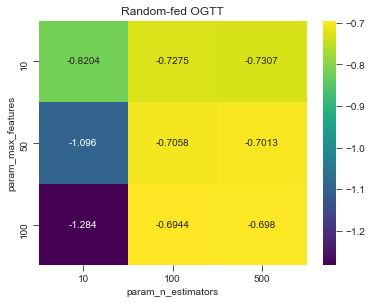

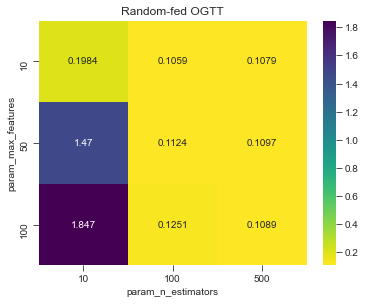

In [145]:
piv = pd.pivot_table(
    ro,  
    index='param_max_features', 
    columns='param_n_estimators', 
    values='mean_test_score')
sns.heatmap(piv, cmap='viridis', annot=True, fmt='.4g')
plt.gcf().set_size_inches(6, 4.5)
plt.title('Random-fed OGTT')

plt.figure()
piv = pd.pivot_table(
    ro,  
    index='param_max_features', 
    columns='param_n_estimators', 
    values='std_test_score')
sns.heatmap(piv, cmap='viridis_r', annot=True, fmt='.4g')
plt.gcf().set_size_inches(6, 4.5)
plt.title('Random-fed OGTT')

In [196]:
divmod(3, 2)

(1, 1)

Text(0.5, 0.01, 'Sampling')

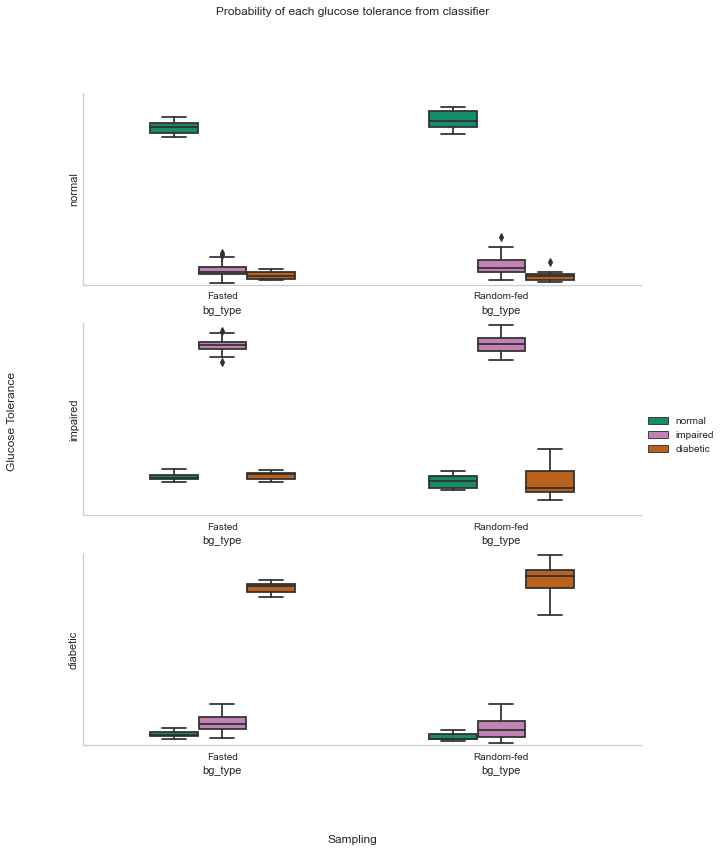

In [332]:
ncols, nrows = 2, 3
i = 0
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, sharey=True, gridspec_kw={'wspace': 0.0})
fig.set_size_inches(10, 12)

for bg_type, bg_cols in zip(['FBG', 'RBG'], [fbg_cols, rbg_cols]):
    for y_name in ['gluc_tol']:
        gs = rfc_bulk_params_gs[bg_type][y_name]['gs_obj']
        df = pd.DataFrame(gs.predict_proba(X_all.loc[bg_cols]), 
                          columns=gs.classes_, index=X_all.loc[bg_cols].index).join(y_3class)
        # bgtype = pd.get_dummies(fg['bg_type'], drop_first=True)
        # bgtype.columns = ['bg_type']
        bgtype = fg['bg_type']
        df = df.join(bgtype.map({'FBG': 'Fasted', 'RBG': 'Random-fed'}))
        for gluc_tol, offset in zip(['normal', 'impaired', 'diabetic'], [0, 2, 4]):
            col, row = divmod(i, nrows)
            ax = axs[row][col]
            i += 1
            sns.boxplot(data=df, x='bg_type', y=gluc_tol, 
                          palette=colors,
                          hue='gluc_tol',
                          dodge=True,
                          ax=ax, 
                       )
            if i != nrows*ncols:
                ax.legend([], [], frameon=False)
            sns.despine(ax=ax, right=True, top=True, left=(False if bg_type=='FBG' else True))
            if bg_type == 'RBG': 
                ax.set_yticks([])
                ax.set_ylabel('')
            else: 
                ax.set_yticks([0, 0.5, 1])
                ax.set_yticklabels([0, 0.5, 1])
            ax.margins(x=0.01, y=0.01)
            
# sns.despine()
plt.legend(loc=(1.01, 1.5))
fig.suptitle('Probability of each glucose tolerance from classifier')
fig.supylabel('Glucose Tolerance')
fig.supxlabel('Sampling')

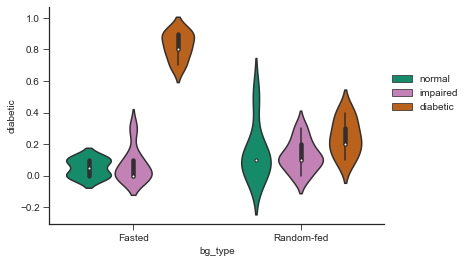

In [152]:
for gluc_tol, offset in zip(['normal', 'impaired', 'diabetic'], [0, 2, 4]):
    sns.violinplot(data=df, x='bg_type', y='diabetic', 
                  palette=colors,
                  hue='gluc_tol',
    #                order=['gluc_tol'],
    #               dodge=True,
    #                positions=[5, 6]
                  )
# sns.swarmplot(data=df, x='bg_type', y='normal', hue='gluc_tol', positions=[2, 3])


<AxesSubplot:xlabel='time', ylabel='total_bill'>

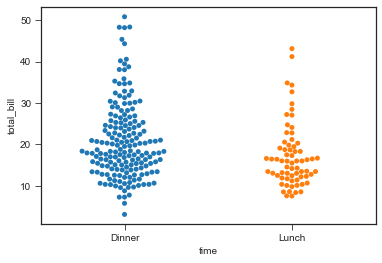

In [89]:
sns.swarmplot(x="time", y="total_bill", data=tips,
                        order=["Dinner", "Lunch"])

In [240]:
X_all.index == y_3class.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

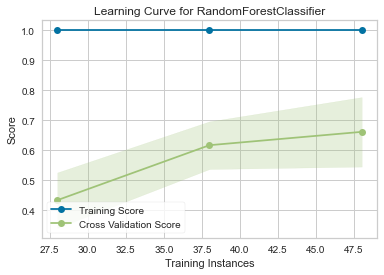

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [306]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from yellowbrick.model_selection import (
    learning_curve, 
    validation_curve, 
    feature_importances, 
    importances,
    rfecv, 
)
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
learning_curve(
    rfc, 
    X_all, 
    y_3class, 
    train_sizes=[0.6, 0.8, 1.0],
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3), 
    n_jobs=-2,
    scoring='accuracy')

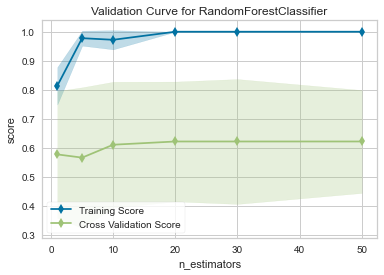

In [304]:
fig, ax = plt.subplots()
n_est_vc = validation_curve(
    rfc, 
    X_all.loc[rbg_cols], 
    y_3class.loc[rbg_cols], 
    param_name='n_estimators',
    param_range=[1, 5, 10, 20, 30, 50],
#     train_sizes=[0.6, 0.8, 1.0],
    cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3), 
    n_jobs=-2,
    scoring='accuracy',
    ax=ax
)


In [302]:
ax.set_ylim(-20, 0)
ax.set_yscale('log')
# plt.yscale('log')
fig

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\matplotlib\transforms.py:2623: RuntimeWarning: divide by zero encountered in double_scalars
  y_scale = 1.0 / inh
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: math domain error

<Figure size 432x288 with 1 Axes>

In [321]:
data.loc['m_367']

Unique ID               unknown_85.02841_11.562
Type                                 metabolite
Proposed ID                             unknown
Found in Tracefinder                        NaN
Compound Class                          unknown
                                 ...           
1074_9_FBG                            22.148826
1062_9_RBG                            23.338492
1101_8_RBG                            23.679326
1092_8_RBG                            22.191944
1092_10_RBG                           22.134555
Name: m_367, Length: 77, dtype: object

C:\Users\bjanderson23\anaconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


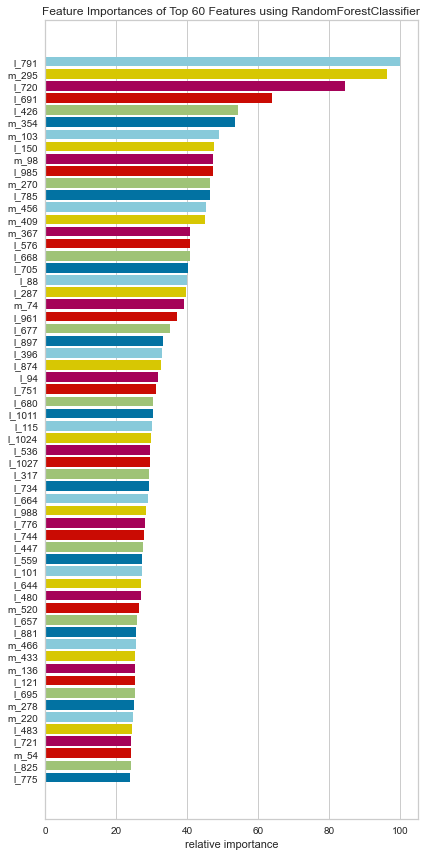

In [328]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 12)
rfc_fi = feature_importances(
    rfc, 
    X_all.loc[rbg_cols], 
    y_3class.loc[rbg_cols], 
    cv=RepeatedStratifiedKFold(n_splits=6, n_repeats=20, random_state=100), 
    n_jobs=-2,
#     scoring='accuracy',
    topn=60,
    ax=ax
)


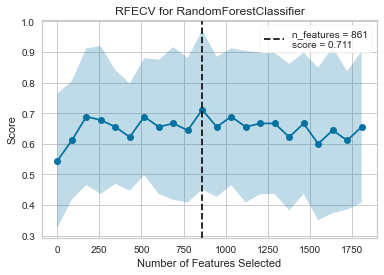

In [318]:
fig, ax = plt.subplots()
# fig.set_size_inches(6, 12)
rfc = RandomForestClassifier(n_jobs=-2)
rfc_rfe = rfecv(
    rfc, 
    X_all.loc[rbg_cols], 
    y_3class.loc[rbg_cols], 
    cv=RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=1), 
    step=0.05,
    n_jobs=-2,
    ax=ax
)

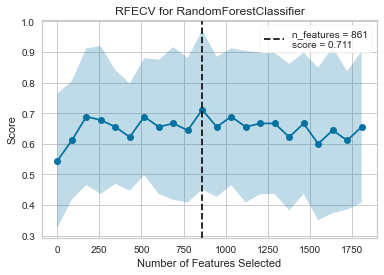

In [320]:
# rfc_rfe_fig = fig
rfc_rfe_fig


In [269]:
# plt.ylim(-50, 50)
n_est_vc.fig.show()

plt.show()

C:\Users\bjanderson23\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


In [259]:
n_est_vc.ax
fig = plt.figure()
fig.add_subplot(n_est_vc.ax)
# plt.show()

ValueError: The Subplot must have been created in the present figure

<Figure size 576x396 with 0 Axes>

# GridSearchCV for hyperparameters

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/

https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

In [6]:
rfc = RandomForestClassifier(n_jobs=7)
cv = RepeatedStratifiedKFold(n_splits=6,
                             n_repeats=3)
params = {
    'n_estimators': [500, 1000, 1500, 2000, 3000],
    'max_features': [20, 30, 40, 50, 60, 80, 100]
}

rfc_gs = GridSearchCV(estimator=RandomForestClassifier(n_estimators=100,),
                     param_grid=params,
                     scoring='r2',
                      cv=cv,
                     n_jobs=7,)
rfc_result = rfc_gs.fit(X_all, y_3class)
# summarize results
print("Best: %f using %s" % (rfc_result.best_score_, rfc_result.best_params_))
means = rfc_result.cv_results_['mean_test_score']
stds = rfc_result.cv_results_['std_test_score']
params = rfc_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: 

In [39]:
l = []
for mean, param in zip(means, params):
    d = {'mean': mean, **param}
    l.append(d)
rfcgsresult = pd.DataFrame(l)

In [42]:
rfcgsresult

,mean,max_features,n_estimators
0,0.666667,20,500
1,0.655556,20,1000
2,0.655556,20,1500
3,0.661111,20,2000
4,0.655556,20,3000
5,0.683333,30,500
6,0.677778,30,1000
7,0.694444,30,1500
8,0.672222,30,2000
9,0.661111,30,3000


In [41]:
rfcgsresult.groupby('max_features').mean()

,mean,n_estimators
max_features,,
20,0.658889,1600.0
30,0.677778,1600.0
40,0.676667,1600.0
50,0.694444,1600.0
60,0.701111,1600.0
80,0.714444,1600.0
100,0.714444,1600.0


In [20]:
pd.DataFrame(params)

,max_features,n_estimators
0,20,500
1,20,1000
2,20,1500
3,20,2000
4,20,3000
5,30,500
6,30,1000
7,30,1500
8,30,2000
9,30,3000


# GridSearchCV conclusion:
## 1. max_features of 60, 80, and 100 are better than the standard sqrt(n_features) = 40-ish
###  80 and 100 are approximately the same, but slightly better than 60, so use max_features = 80
## 2. n_estimators has a slight trend where accuracy is maximized around 1500

## Perform 3 experiments
1. RF classification (N/I/D) with all features
1. RF classification (N/I/D) with only features that converged under full model
2. RF classification (N/I/D) with only features significant under glucose tolerance and glucose tolerance x sampling

## Hypothesis: RF is robust to non-informative features, so leave-one-out CV will show all 3 models perform approximately the same



In [3]:
# # Generate data labels (y) for RF Classifier 

# y_3class = fg.set_index('combined_col_name')['glucose_tolerance']
# y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})
# y_cont = fg.set_index('combined_col_name')['bg']
# X_all = data[data_cols].T
# X_only_conv = data.loc[~data[pval_cols].isna().all(axis=1), data_cols].T
# gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
#                  'fdr corrected pval effect of interaction sampling and glucose tolerance']
# X_only_signf = data.loc[(data[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T

## 3 training data sets:
### 1) RF classifier with all features
### 2) RF classifier with only features that converged under full model
### 3) RF classification (N/I/D) with only features significant under glucose tolerance and glucose tolerance interaction with sampling (gluc_tol x feeding)

In [6]:
# X_all = StandardScaler().fit_transform(data[data_cols].T)
# X_only_conv = StandardScaler().fit_transform(data.loc[~data[pval_cols].isna().all(axis=1), data_cols].T)
# gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
#                  'fdr corrected pval effect of interaction sampling and glucose tolerance']
# X_only_signf = StandardScaler().fit_transform(data.loc[(data[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T)

X_all = data[data_cols].T
X_only_conv = data.loc[~data[pval_cols].isna().all(axis=1), data_cols].T
gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
                 'fdr corrected pval effect of interaction sampling and glucose tolerance']
X_only_signf = data.loc[(data[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T

# Generate y 
# ['normal', 'impaired', 'diabetic']
y_3class = fg.set_index('combined_col_name')['glucose_tolerance']
# [0, 1, 2]
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})
# random/fasted blood glucoose
y_cont = fg.set_index('combined_col_name')['bg']
# ogtt result
ogtt_dict = animal_phenotypes.set_index('animal').to_dict()['OGTT (AUC)']
y_ogtt = fg[['combined_col_name', 'animal']].set_index('combined_col_name')['animal'].map(ogtt_dict)

In [5]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=1)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=1)
n_scores = cross_val_score(estimator=rfc,
                           X=X_all,
                           y=y_3class,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.750 (0.087)


In [8]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=100)
n_scores = cross_val_score(estimator=rfc,
                           X=X_only_conv,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.750 (0.144)


In [10]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=100)
n_scores = cross_val_score(estimator=rfc,
                           X=X_only_signf,
                           y=y,
                           cv=cv,
                           scoring='accuracy', 
                           n_jobs=-1,
                           error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.700 (0.135)


## Another experiment:
2. RF with indicator variable {0, 1} for FBG/RBG in training data 

## Hypothesis: mild increase in accuracy. 

In [12]:
sampling_indicator_var = fg.set_index('combined_col_name')['bg_type'].map({'FBG': 0, 'RBG': 1})

In [13]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=5, random_state=100)
n_scores = cross_val_score(estimator=rfc, X=X_all.join(sampling_indicator_var), y=y, cv=cv,
                           scoring='accuracy', n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.687 (0.177)


In [40]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=5, random_state=100)
n_scores = cross_val_score(estimator=rfc, X=X_only_conv.join(sampling_indicator_var), y=y, cv=cv,
                           scoring='accuracy', n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.710 (0.165)


([<matplotlib.axis.XTick at 0x234ff095a88>,
 [Text(0.1, 0, '20'),
  Text(1.1, 0, '40'),
  Text(2.1, 0, '60'),
  Text(3.1, 0, '80'),
  Text(4.1, 0, '100')])

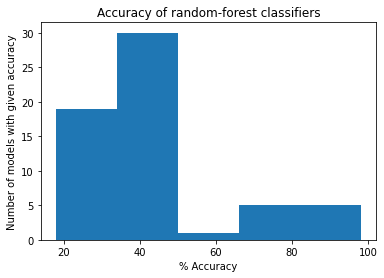

In [67]:
plt.hist([str(x) for x in n_scores*100], bins=5)
plt.title('Accuracy of random-forest classifiers')
plt.xlabel('% Accuracy')
plt.ylabel('Number of models with given accuracy')
plt.xticks(ticks=[0.1 + x for x in[0, 1, 2, 3, 4]], labels=[20, 40, 60, 80, 100])

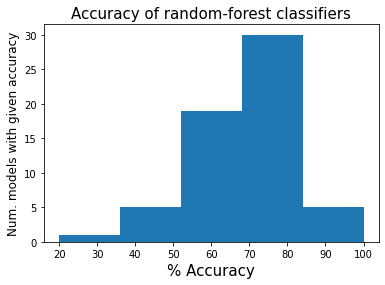

In [75]:
plt.hist(n_scores*100, bins=5)
plt.title('Accuracy of random-forest classifiers', fontsize=15)
plt.xlabel('% Accuracy', fontsize=15)
plt.ylabel('Num. models with given accuracy', fontsize=12)
# plt.xticks(ticks=[0.1 + x for x in[0, 1, 2, 3, 4]], labels=[20, 40, 60, 80, 100])
plt.savefig(r'..\reports\figures\3-5-2\RF_classifier_accuracy.png')

In [74]:
np.mean(n_scores)

0.7099999999999999

In [15]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=100)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=3, random_state=100)
n_scores = cross_val_score(estimator=rfc, X=X_only_signf.join(sampling_indicator_var), y=y, cv=cv,
                           scoring='accuracy', n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.703 (0.173)


(array([ 9.,  0.,  0., 17.,  0.,  0., 28.,  0.,  0.,  6.]),
 array([0.4 , 0.46, 0.52, 0.58, 0.64, 0.7 , 0.76, 0.82, 0.88, 0.94, 1.  ]),
 <BarContainer object of 10 artists>)

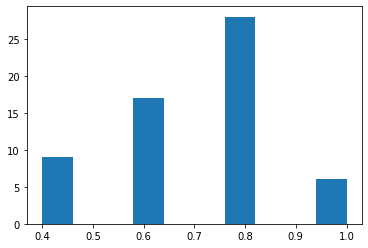

In [16]:
plt.hist(n_scores)

## RF Regressor

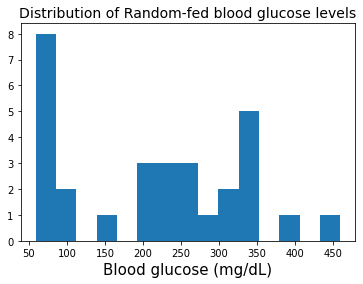

In [83]:
plt.hist(y_continuous[y_continuous.index.str.contains('RBG')], bins=15)
plt.title('Distribution of Random-fed blood glucose levels', fontsize=14)
plt.xlabel('Blood glucose (mg/dL)', fontsize=15)
plt.savefig(r'..\reports\figures\3-5-2\random_fed_blood_gluc_distribution.png')

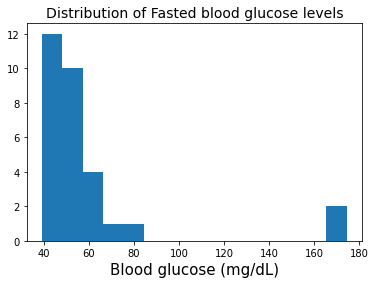

In [84]:
plt.hist(y_continuous[y_continuous.index.str.contains('FBG')], bins=15)
plt.title('Distribution of Fasted blood glucose levels', fontsize=14)
plt.xlabel('Blood glucose (mg/dL)', fontsize=15)
plt.savefig(r'..\reports\figures\3-5-2\fasted_blood_gluc_distribution.png')

In [34]:
rfr = RandomForestRegressor()  

# evaluate the model
## To do leave-one-out, set n_splits = n_observations in your training data 
cv = RepeatedKFold(n_splits=60, n_repeats=3, random_state=1)
n_scores = cross_val_score(estimator=rfr, 
#                            X=X_only_signf.join(sampling_indicator_var), 
                           X=X_only_signf,
                           y=y_continuous, 
                           scoring='neg_mean_absolute_error', 
                           cv=cv, 
                           n_jobs=-1, 
                           error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -25.302 (38.365)


In [85]:
rfr = RandomForestRegressor()  

# evaluate the model
## To do leave-one-out, set n_splits = n_observations in your training data 
cv = RepeatedKFold(n_splits=60, n_repeats=3, random_state=1)
rfr_scores = cross_val_score(estimator=rfr, 
                           X=X_only_signf.join(sampling_indicator_var), 
#                            X=X_only_signf,
                           y=y_continuous, 
                           scoring='neg_mean_absolute_error', 
                           cv=cv, 
                           n_jobs=-1, 
                           error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (np.mean(rfr_scores), np.std(rfr_scores)))

MAE: 0.710 (0.165)


In [88]:
(np.mean(rfr_scores), np.std(rfr_scores), np.median(rfr_scores))

(-24.65602777777777, 37.63407078521418, -11.289999999999992)

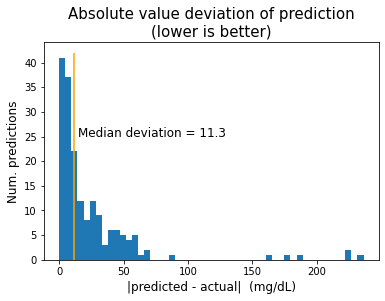

In [107]:
plt.hist(rfr_scores*-1, bins=50);
plt.title('Absolute value deviation of prediction\n(lower is better)', fontsize=15)
plt.xlabel('|predicted - actual|  (mg/dL)', fontsize=12)
plt.ylabel('Num. predictions', fontsize=12)
plt.vlines(x=11.3, ymin=0, ymax=42, color='orange')
plt.annotate('Median deviation = 11.3', xy=(15, 25), fontsize=12)
plt.savefig(r'..\reports\figures\3-5-2\RF_regressor_abs_deviation.png', bbox_inches='tight')

## Show Confusion Matrix for RF models

In [15]:
y_3class

,glucose_tolerance
combined_col_name,
1076_10_FBG,2
1062_8_FBG,1
1093_9_FBG,0
1060_8_RBG,1
1091_10_FBG,0
1092_9_RBG,1
1093_10_RBG,0
1082_10_FBG,2
1060_9_RBG,1


In [63]:
y_pred_3class

array(['impaired', 'impaired', 'normal', 'impaired', 'normal', 'impaired',
       'normal', 'impaired', 'impaired', 'impaired', 'impaired', 'normal',
       'impaired', 'impaired', 'diabetic', 'impaired', 'impaired',
       'normal', 'impaired', 'diabetic', 'diabetic', 'normal', 'impaired',
       'diabetic', 'impaired', 'impaired', 'impaired', 'normal',
       'impaired', 'impaired', 'impaired', 'diabetic', 'normal',
       'impaired', 'impaired', 'impaired', 'diabetic', 'diabetic',
       'diabetic', 'impaired', 'impaired', 'impaired', 'impaired',
       'impaired', 'impaired', 'impaired', 'impaired', 'diabetic',
       'impaired', 'impaired', 'impaired', 'impaired', 'diabetic',
       'impaired', 'impaired', 'impaired', 'impaired', 'impaired',
       'impaired', 'normal'], dtype=object)

In [108]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=10)
y_pred_3class_num = cross_val_predict(rfc, 
                                  X=X_all, y=y_3class_num, 
                                  cv=cv)

In [104]:
# Cross val PREDICT
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=10)
y_pred_3class = cross_val_predict(rfc, 
                                  X=X_all, y=y_3class, 
                                  cv=cv)

In [ ]:
# Cross val SCORE
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=10)
y_pred_3class = cross_val_score(rfc, 
                                X=X_all, y=y_3class, 
                                cv=cv)

## Get the ROC AUC for each split in the CV:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

In [198]:
rfc.fit(X.iloc[train], y[train])

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [201]:
rfc.predict_proba(X.iloc[test])

array([[0.182, 0.693, 0.125],
       [0.321, 0.487, 0.192],
       [0.339, 0.586, 0.075],
       [0.213, 0.696, 0.091],
       [0.533, 0.409, 0.058]])

ValueError: multiclass format is not supported

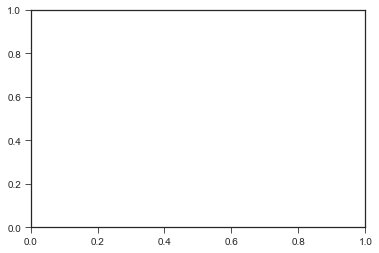

In [279]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
svc = SVC()
clf = rfc
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=1, random_state=10)
X = X_all
y = y_3class
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    clf.fit(X.iloc[train], y[train])
#     viz = RocCurveDisplay.from_estimator(   # from_estimator 
#         clf,
#         X.iloc[test],
#         y[test],
#         name="ROC fold {}".format(i),
#         alpha=0.3,
#         lw=1,
#         ax=ax,)
    viz = RocCurveDisplay.from_predictions(   # from_predictions
        y_true=y[test],
        y_pred=clf.predict_proba(X.iloc[test]),
        name="ROC fold {}".format(i),
        ax=ax,
        alpha=0.3,
        lw=1,)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="Receiver operating characteristic example",
)
ax.legend(loc="lower right")
plt.show()

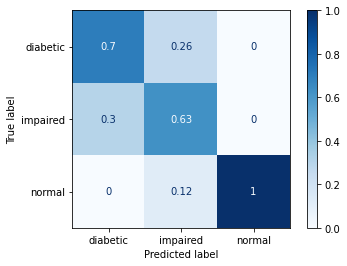

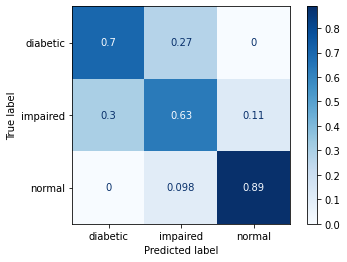

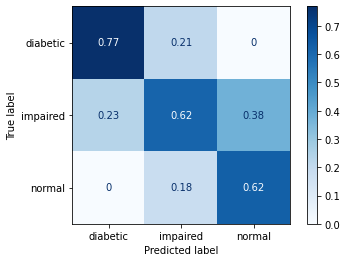

In [105]:
# Compare confusion matrix between subsets of metabolite features for Random Forest
for dataset in [X_all, X_only_conv, X_only_signf]:
    y_pred = cross_val_predict(rfc, X=dataset, y=y_3class, cv=cv)
    ConfusionMatrixDisplay.from_predictions(y_3class, y_pred, 
                                            cmap='Blues',
                                            normalize='pred')

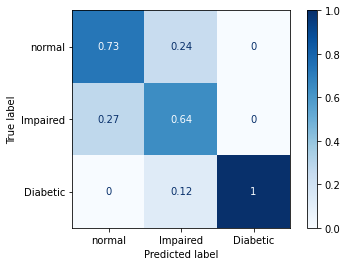

In [106]:
ConfusionMatrixDisplay.from_predictions(y_3class, y_pred_3class, 
                                        display_labels=['normal', 'Impaired', 'Diabetic'], 
                                        cmap='Blues',
                                        normalize='pred')

## Try making a ROC AUC curve for Random Forest multiclass

### roc_auc_score() requires y_true and y_score, but RF doesn't have a .decision_function() method to generate  score

### Therefore, use RF.predict_proba()

### See: https://laurenliz22.github.io/roc_curve_multiclass_predictions_random_forest_classifier

In [204]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_3class, test_size=0.2, random_state=10)
rfc.fit(X_train, y_train)
y_score = rfc.predict_proba(X_test)
y_pred = rfc.predict(X_test)

In [190]:
y_score

array([[0.6 , 0.37, 0.03],
       [0.21, 0.58, 0.21],
       [0.66, 0.31, 0.03],
       [0.09, 0.51, 0.4 ],
       [0.12, 0.46, 0.42],
       [0.18, 0.29, 0.53],
       [0.17, 0.7 , 0.13],
       [0.14, 0.56, 0.3 ],
       [0.44, 0.51, 0.05],
       [0.3 , 0.57, 0.13],
       [0.08, 0.87, 0.05],
       [0.41, 0.45, 0.14]])

In [191]:
roc_auc_score(y_test, y_score, 
              multi_class='ovo',
              average='macro')

0.9805555555555556

## Using sklearn's classification_report(), find the average 

In [214]:
pd.DataFrame(classification_report(y_true=y_test, y_pred=y_pred, output_dict=True))

,diabetic,impaired,normal,accuracy,macro avg,weighted avg
precision,1.000000,0.375000,1.000000,0.583333,0.791667,0.843750
recall,0.750000,1.000000,0.200000,0.583333,0.650000,0.583333
f1-score,0.857143,0.545455,0.333333,0.583333,0.578644,0.560967
support,4.000000,3.000000,5.000000,0.583333,12.000000,12.000000


## Feature importance and permutation testing
## This is not Permutation testing, just the .feature_importances_ attribute from a fitted model
https://scikit-learn.org/stable/modules/permutation_importance.html

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py

https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html#sphx-glr-auto-examples-model-selection-plot-permutation-tests-for-classification-py

In [8]:
cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=3, random_state=1)
rfc = RandomForestClassifier(n_estimators=1500,
                             max_features=80,
                             n_jobs=7, random_state=1)
rfc_models = []  # save fitted models
fis = []  # feature importances
for train, test in cv.split(X_all, y_3class):
    X_train = X_all.iloc[train]
    X_test = X_all.iloc[test]
    y_train = y_3class.iloc[train]
    y_test = y_3class.iloc[test]
    fit = rfc.fit(X_train, y_train)
    fis.append(fit.feature_importances_)
    rfc_models.append(fit)
    print('done')

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [9]:
rfc_models[0]

RandomForestClassifier(max_features=80, n_estimators=1500, n_jobs=7,
                       random_state=1)

Text(0.5, 1.0, 'Feature importances for all')

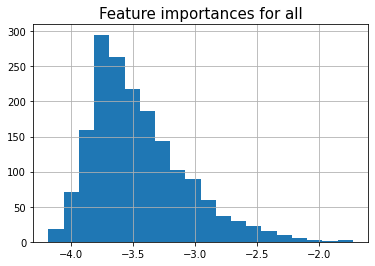

In [94]:
fidf = pd.DataFrame(fis)
np.log10(fidf.mean(axis=0)).hist(bins=20)
plt.title('Feature importances for all', fontsize=15)

## Permutation Importance testing

In [11]:
fitted_rfc = rfc_models[0]

for train, test in cv.split(X_all, y_3class):
    X_train = X_all.iloc[train]
    X_test = X_all.iloc[test]
    y_train = y_3class.iloc[train]
    y_test = y_3class.iloc[test]
    break

pi = permutation_importance(fitted_rfc, X_train, y_train, 
                            n_repeats=20, 
                            n_jobs=7,
                            random_state=1,)
# perm_sorted_idx = result.importances_mean.argsort()

In [21]:
pd.Series(pi['importances_mean'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1722    0.0
1723    0.0
1724    0.0
1725    0.0
1726    0.0
Length: 1727, dtype: float64

In [14]:
pd.DataFrame(pi)

ValueError: Data must be 1-dimensional

# Both feature_importances_ and permutation testing show that many features have low importance 

## Permutation testing returns exactly 0 importance for all features

## Because many features are undoubtedly correlated/multicolinear, we can cluster the features and then run feature importance on those:
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

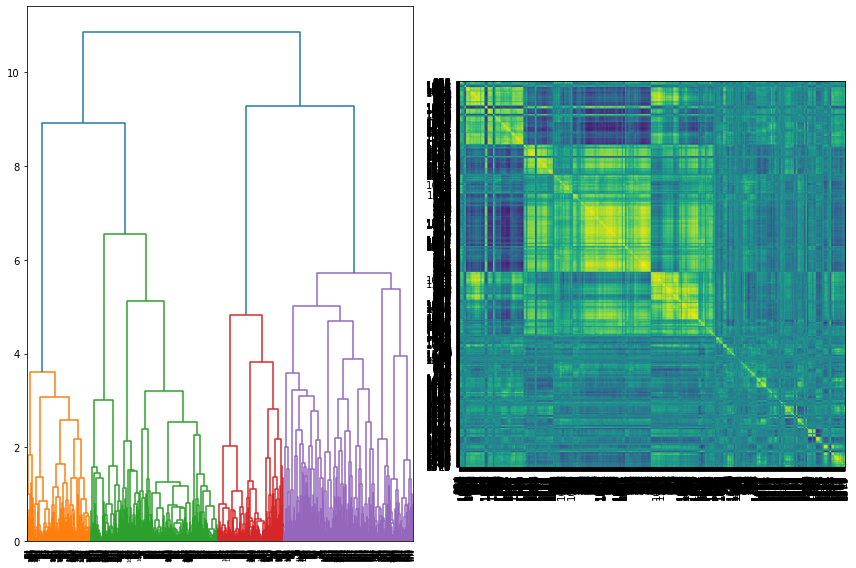

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_all).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, 
#     labels=data.feature_names.tolist(), 
    ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [51]:
distance_matrix

array([[0.        , 0.34053904, 0.52170047, ..., 0.98749653, 0.99672131,
        0.93153654],
       [0.34053904, 0.        , 0.49480411, ..., 0.79277577, 0.80933593,
        0.80088914],
       [0.52170047, 0.49480411, 0.        , ..., 0.82028341, 0.83878855,
        0.82383996],
       ...,
       [0.98749653, 0.79277577, 0.82028341, ..., 0.        , 0.02133926,
        0.08357877],
       [0.99672131, 0.80933593, 0.83878855, ..., 0.02133926, 0.        ,
        0.09780495],
       [0.93153654, 0.80088914, 0.82383996, ..., 0.08357877, 0.09780495,
        0.        ]])

In [ ]:
hierarchy.

In [53]:
dist_linkage

array([[1.68800000e+03, 1.69300000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.19300000e+03, 1.19400000e+03, 7.22422895e-04, 2.00000000e+00],
       [1.43300000e+03, 1.43400000e+03, 2.77854960e-03, 2.00000000e+00],
       ...,
       [3.43900000e+03, 3.44900000e+03, 8.92097167e+00, 8.56000000e+02],
       [3.44400000e+03, 3.44800000e+03, 9.28022866e+00, 8.71000000e+02],
       [3.45000000e+03, 3.45100000e+03, 1.08659474e+01, 1.72700000e+03]])

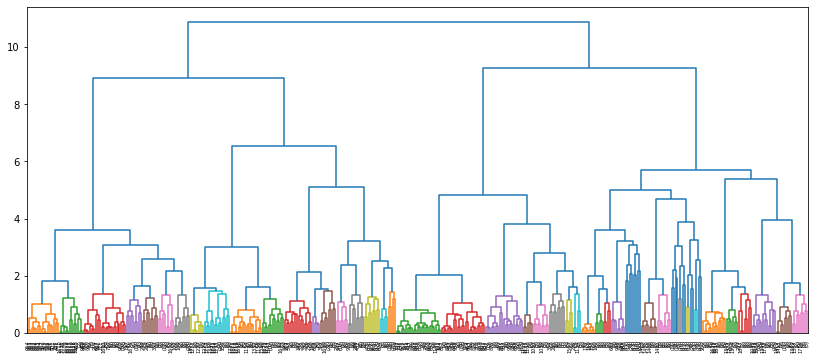

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))
# ax.set_xticks(ticks=[None]*1729)
dendro = hierarchy.dendrogram(
    dist_linkage, 
    p=8,
    truncate_mode='level',
    color_threshold=1.5,
#     labels=data.feature_names.tolist(), 
    labels=None,
    ax=ax, 
    leaf_rotation=90,)

In [46]:
X_train.iloc[:, selected_features]

i,l_0,l_3,l_13,l_14,l_17,l_23,l_27,l_29,l_40,l_43,...,m_462,m_594,m_641,m_579,m_390,m_442,m_321,m_168,m_431,m_2
1076_10_FBG,20.405355,24.400930,20.661081,22.972376,18.324009,17.589136,19.724096,22.209547,20.477756,22.411665,...,22.542372,20.191981,20.623125,21.212959,23.104139,22.667849,22.306697,23.745832,22.543791,29.735454
1062_8_FBG,23.313111,26.811664,23.975225,24.280319,21.428115,21.584913,22.431345,23.889556,23.488381,23.168277,...,22.663886,20.498545,20.640129,21.158338,22.898562,22.288478,21.895666,23.367905,21.805219,29.569621
1093_9_FBG,23.218699,26.708762,23.978376,23.622947,21.761263,23.237721,22.444580,23.417813,21.941928,23.891675,...,22.666288,20.399734,20.535819,21.374062,23.062241,22.766897,22.251553,23.798067,21.994352,30.043032
1060_8_RBG,24.012349,25.977120,24.584823,24.320035,22.087831,21.905794,23.084970,25.276589,23.590325,23.482645,...,22.333832,20.404940,20.614524,21.228774,23.115034,22.668681,22.148089,23.622888,22.429967,29.827946
1091_10_FBG,24.302356,27.313654,23.473364,23.711949,22.250819,21.996433,22.242289,23.958850,22.110955,23.821085,...,22.370538,20.664451,20.616503,21.147437,23.005716,22.574107,22.405596,23.831533,21.549027,29.420633
1092_9_RBG,23.901455,27.337061,23.598042,23.954512,21.391864,22.407053,22.144910,23.580785,21.477723,22.464756,...,22.248717,20.152168,20.738324,21.237580,23.081268,22.491746,21.007247,23.575978,22.060292,29.483693
1093_10_RBG,23.883301,27.415597,22.661012,23.314001,21.373437,22.384447,22.181923,23.867462,22.203506,23.832991,...,22.291932,20.497893,20.279148,21.166290,22.987817,22.478029,22.561237,23.960164,22.010572,29.886091
1082_10_FBG,23.387975,27.230430,24.208826,23.406087,21.350521,21.423034,22.156868,23.950272,21.917178,21.923677,...,22.267686,20.113345,20.677852,21.516908,23.085969,22.666382,22.262143,23.629210,22.383977,29.609038
1060_9_RBG,24.421692,27.598719,22.214648,23.333342,22.168219,22.915789,21.281535,23.666358,19.222029,23.973685,...,20.136739,21.827766,19.498839,20.705267,23.021768,22.650472,23.146591,24.711479,18.856624,30.018239
1101_9_FBG,23.463756,27.126653,23.808922,23.355547,21.537200,21.592998,22.517853,23.985849,22.162878,23.582506,...,22.557435,20.392364,20.613885,21.356330,23.107504,22.586731,22.486640,23.343022,22.001319,29.620839


In [47]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=1500, max_features=80, random_state=1)
clf_sel.fit(X_train_sel, y_train)
print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)

Accuracy on test data with features removed: 0.80


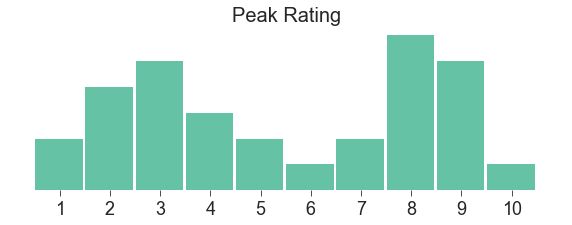

In [250]:
color = sns.color_palette('Set2')[0]
plt.style.use('seaborn-ticks')
hdata = [1, 1,
        2, 2, 2, 2,
        3, 3, 3, 3, 3,
        4, 4, 4, 
        5, 5, 
        6, 
        7, 7, 
        8, 8, 8, 8, 8, 8, 
        9, 9, 9, 9, 9, 
        10]

plt.hist(hdata, width=0.85, color=color)
plt.title('Peak Rating Distribution', fontsize=20)
plt.gcf().set_size_inches(10, 3)
plt.xticks(ticks=[0.9*(x +0.6) for x in range(1, 11)], labels=range(1, 11), fontsize=18)
# plt.xlabel('Peak Rating', fontsize=20)
plt.xlim(0.5, 10.5)
plt.yticks([])
sns.despine(left=True, bottom=True)

In [ ]:
color = sns.color_palette('Set2')[0]
plt.style.use('seaborn-ticks')
data = [1, 1,
        2, 2, 2, 2,
        3, 3, 3, 3, 3,
        4, 4, 4, 
        5, 5, 
        6, 
        7, 7, 
        8, 8, 8, 8, 8, 8, 
        9, 9, 9, 9, 9, 
        10]

plt.hist(data, width=0.85, color=color)
plt.title('Jaggedness factor', fontsize=20)
plt.gcf().set_size_inches(10, 3)
plt.xticks(ticks=[0.9*(x +0.6) for x in range(1, 11)], labels=range(1, 11), fontsize=18)
plt.xlabel('Peak Rating', fontsize=20)
plt.xlim(0.5, 10.5)
plt.yticks([])
sns.despine(left=True, bottom=True)